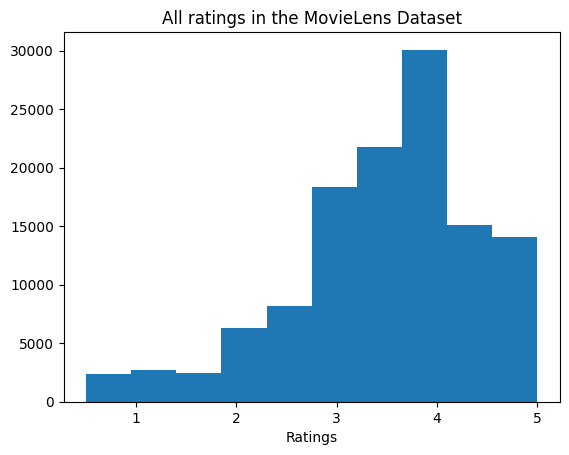

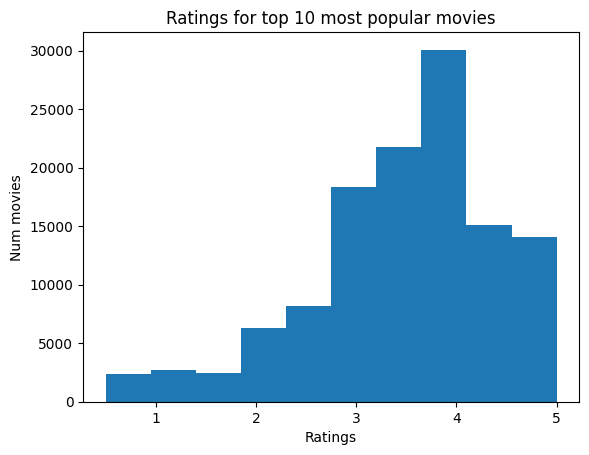

479


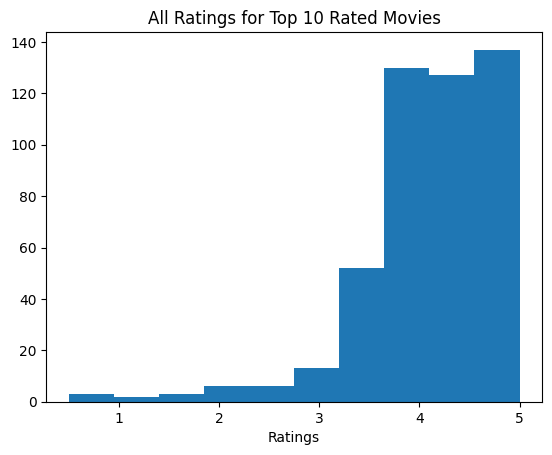

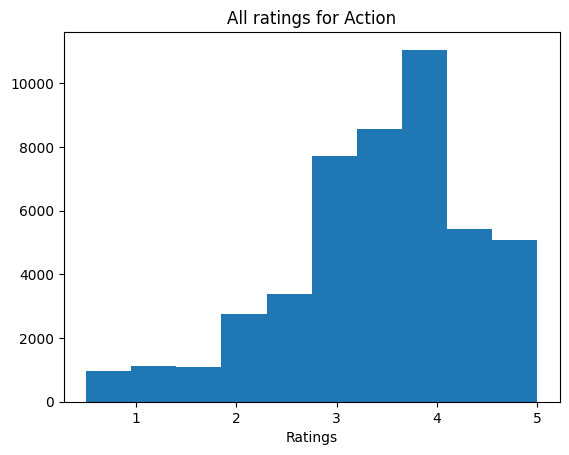

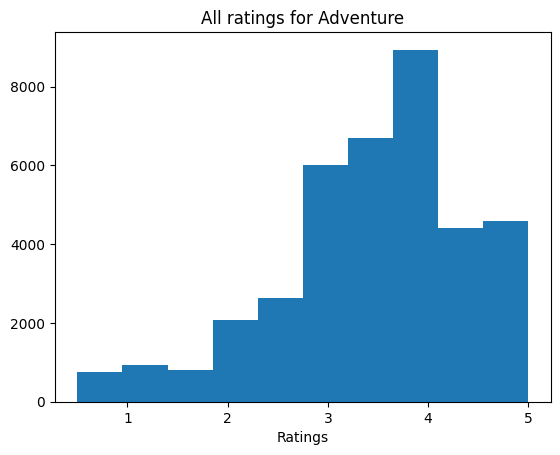

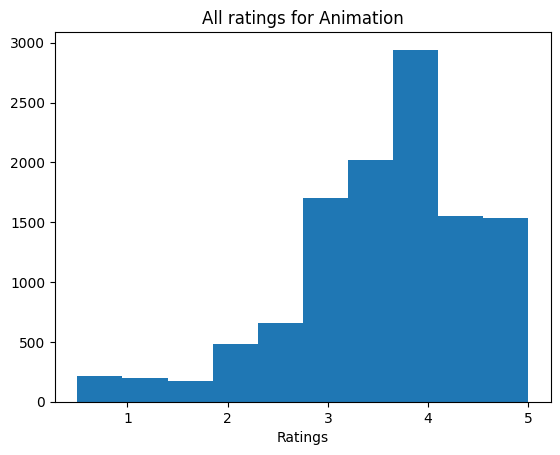

In [100]:
import numpy as np
from utils import read_data, K
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from utils import read_data
import pandas as pd
from data_processing import *

In [55]:
def grad_U(Ui, Yij, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    return eta * ((reg * Ui) - Vj * 2 * (Yij -mu - np.dot(Ui,Vj) -ai -bj))
    
def grad_V(Vj, Yij, Ui, reg, eta, ai, bj, mu):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * ((reg * Vj) - Ui * 2 * (Yij -mu - np.dot(Ui,Vj) -ai -bj))

def grad_a(Ui, Yij, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    return eta * ((reg * ai) - 2 * (Yij -mu - np.dot(Ui,Vj) -ai -bj))
    
def grad_b(Ui, Yij, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * ((reg * bj) - 2 * (Yij -mu - np.dot(Ui,Vj) -ai -bj))


def get_err(U, V, Y, reg, a, b, mu):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    error = 0
    
    for k in range(len(Y)):
        i = Y[k][0]
        j = Y[k][1]
        Yij = Y[k][2]
        
        error += 0.5* (Yij - mu - np.matmul(np.transpose(U[i-1]),V[j-1]) - a[i-1] - b[j-1] ) ** 2
        
    error += reg/2 * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2 
                      + np.linalg.norm(a)**2
                      + np.linalg.norm(b)**2)
    
    return error/len(Y)
      


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    a = np.random.uniform(-0.5, 0.5, (M))
    b = np.random.uniform(-0.5, 0.5, (N))

    mu = np.mean(Y[2])
    
    epoch = 0
    
    errs = []
    
    while epoch < max_epochs:
        itinerary = np.random.permutation(len(Y))
        
        for k in itinerary:
            i = Y[k][0]
            j = Y[k][1]
            Yij = Y[k][2]
            
            Ui = U[i-1]
            Vj = V[j-1]
            ai = a[i-1]
            bj = b[j-1] 
            
            Ugrad = grad_U(Ui, Yij, Vj, reg, eta, ai, bj, mu)
            Vgrad = grad_V(Vj, Yij, Ui, reg, eta, ai, bj, mu)
            Agrad = grad_a(Ui, Yij, Vj, reg, eta, ai, bj, mu)
            Bgrad = grad_b(Ui, Yij, Vj, reg, eta, ai, bj, mu)
        
            U[i - 1] -= Ugrad
            V[j - 1] -= Vgrad
            a[i - 1] -= Agrad
            b[j - 1] -= Bgrad
        
        errs.append(get_err(U, V, Y, reg, a,b, mu))
        
        if(epoch > 0 and (errs[-2]-errs[-1])/(errs[0]-errs[1]) <= eps):
            break;

        epoch += 1   
    
    
        
    return (U,V,a,b,errs[-1])


def compute_num_users_and_movies(data):
    num_users = np.max(data['User ID']) + 1  # User IDs are zero-indexed
    num_movies = np.max(data['Movie ID']) + 1  # Movie IDs are zero-indexed

    return num_users, num_movies


def get_U_V_a_b(data):
    num_users, num_movies = compute_num_users_and_movies(data)
    eta = 0.03
    reg = 0.1
    eps = 0.0001
    max_epochs = 300

    data_as_numpy = data.to_numpy(copy=True).astype(int)

    U, V, a, b, _ = train_model(num_users, num_movies, K, eta, reg,
                                    data_as_numpy, eps=eps, max_epochs=max_epochs)

    return U.T, V.T, a, b


In [56]:
data, movies = read_data()
U, V, a, b = get_U_V_a_b(data)

In [96]:
 num_movies

1500

In [93]:
np.shape(V)

(20, 1500)

In [94]:
np.shape(data)

(121501, 3)

In [60]:
num_users, num_movies = compute_num_users_and_movies(data)
eta = 0.03
reg = 0.1
eps = 0.0001
max_epochs = 300
data_as_numpy = data.to_numpy(copy=True).astype(int)

In [61]:
A, S, B = np.linalg.svd(V)
approx_V = np.dot(A[:, :2].T, V)
approx_U = np.dot(A[:, :2].T, U)

In [112]:
# %%
# just grab first 10 movies
# TODO: abstract this out so we pick 10 actually useful movies, like use indices
to_viz_np = approx_V[:, :10]
to_viz_df = pd.DataFrame(to_viz_np.T, columns = ['x', 'y'])

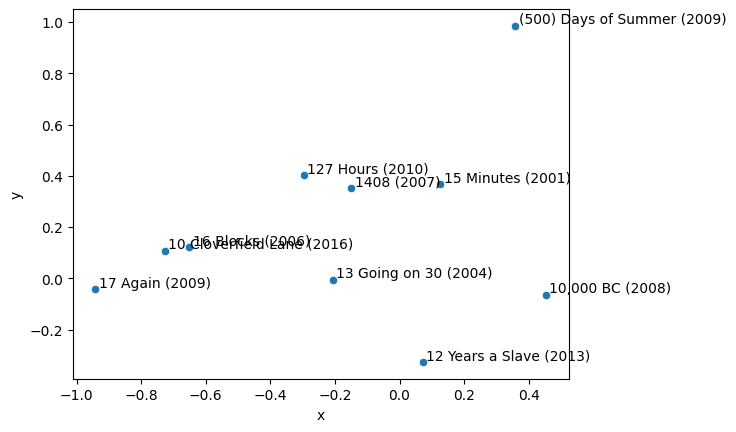

In [70]:
# plot the points.
ax = sns.scatterplot(to_viz_df, x='x', y='y')

movie_titles = movies['Movie Title']
# TODO: if update above, then update below
first_10 = movie_titles[:10]

for i, (x, y) in to_viz_df.iterrows():
  # TODO: also might need to change the first_10[i] here too.
  ax.text(x+.01, y+.01, str(first_10[i]))

In [92]:
bestmovies

,User ID,Movie ID,Rating
88901,734,982,5.0
88895,734,432,5.0
49772,419,123,5.0
49780,419,862,5.0
49787,419,793,5.0
49792,419,1253,5.0
88885,734,310,5.0
49796,419,981,5.0
49732,419,1462,5.0
73739,633,1168,5.0


In [102]:
bestmovies=get_top_ten_most_popular_movie_ids()

In [124]:
# just grab first 10 movies
# TODO: abstract this out so we pick 10 actually useful movies, like use indices
to_viz_np = []
movie_titles = movies['Movie Title']
besttitles = []
for i in bestmovies:
    to_viz_np.append(approx_V[:,i])
    besttitles.append(movie_titles[i])
to_viz_np = np.array(to_viz_np)

In [125]:
to_viz_df = pd.DataFrame(to_viz_np, columns = ['x', 'y'])

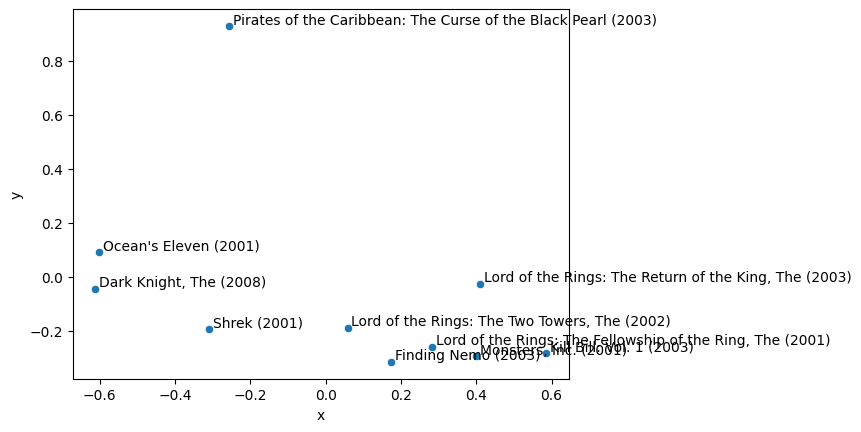

In [127]:
# plot the points.
ax = sns.scatterplot(to_viz_df, x='x', y='y')

# TODO: if update above, then update below
first_10 = movie_titles[:10]

for i, (x, y) in to_viz_df.iterrows():
  # TODO: also might need to change the first_10[i] here too.
  ax.text(x+.01, y+.01, str(besttitles[i]))